In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_test_data = [train, test]

def barplot(x_name, dataframe):
    ax = sns.barplot(x=x_name, y='Survived', data=dataframe)
    plt.show()

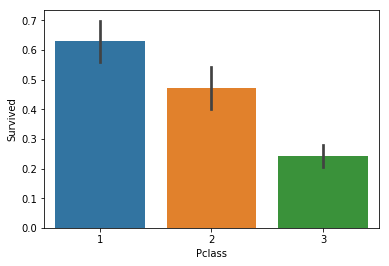

In [3]:
barplot('Pclass', train)

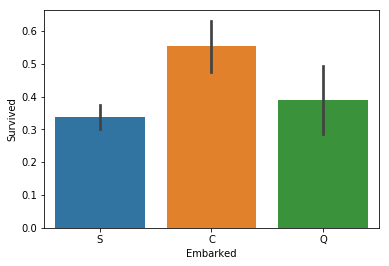

In [4]:
barplot('Embarked', train)

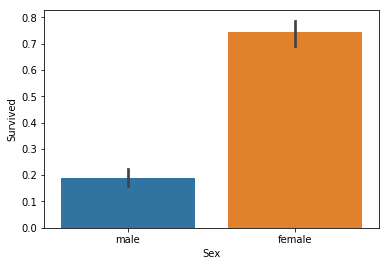

In [5]:
barplot('Sex', train)

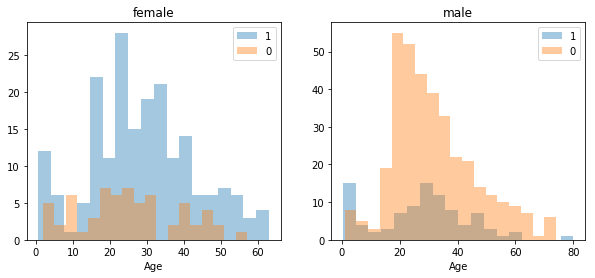

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axid = 0
for sex in ['female', 'male']:
    for surv in [1, 0]:
        ax = sns.distplot(train[(train['Sex'] == sex) & (train['Survived'] == surv)].Age.dropna(),
                          bins=18, label=str(surv), ax=axes[axid], kde=False)
    axid += 1
    ax.legend()
    ax.set_title(sex)
plt.show()

In [7]:
total = train.isnull().sum().sort_values(ascending=False)
print(total.head(5))

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
dtype: int64


In [8]:
### Name
all_data = pd.concat([train, test])
all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print(all_data['Title'].value_counts())

titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}

for dataset in train_test_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                 'Jonkheer', 'Dona', 'Mlle', 'Ms', 'Mme'], 'Other')
    dataset['Title'] = dataset['Title'].map(titles)

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Mlle          2
Major         2
Countess      1
Dona          1
Jonkheer      1
Sir           1
Capt          1
Mme           1
Lady          1
Don           1
Name: Title, dtype: int64


In [9]:
### Sex
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [10]:
### Age
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby('Title')['Age'].transform("median"), inplace=True)

all_data = pd.concat([train, test])
all_data['Age'] = all_data['Age'].astype(int)
all_data['AgeBand'] = pd.cut(all_data['Age'], 5)
print(all_data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True))

         AgeBand  Survived
0  (-0.08, 16.0]  0.548077
1   (16.0, 32.0]  0.328032
2   (32.0, 48.0]  0.436275
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


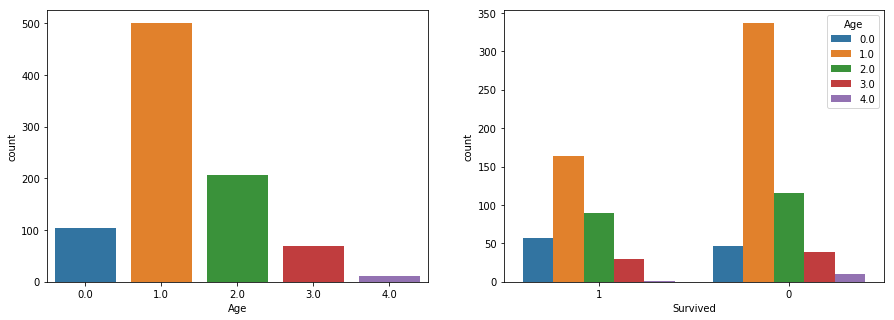

In [11]:
for dataset in train_test_data:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3,
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='Age', data=train, ax=axis1)
sns.countplot(x='Survived', hue="Age", data=train, order=[1,0], ax=axis2)
plt.show()

In [12]:
### Embarked
print(all_data['Embarked'].value_counts())
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}

for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [13]:
### Fare
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

all_data = pd.concat([train, test])
all_data['FareBand'] = pd.cut(all_data['Fare'], 4)
print(all_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True))

             FareBand  Survived
0   (-0.512, 128.082]  0.368113
1  (128.082, 256.165]  0.724138
2  (256.165, 384.247]  0.666667
3  (384.247, 512.329]  1.000000


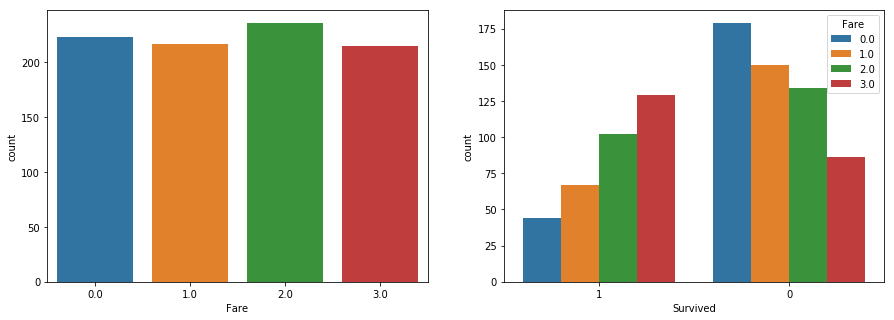

In [14]:
for dataset in train_test_data:
    dataset.loc[dataset['Fare'] <= 7.896, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 7.896) & (dataset['Fare'] <= 14.454), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31.275), 'Fare'] = 2,
    dataset.loc[dataset['Fare'] >= 31.275, 'Fare'] = 3

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='Fare', data=train, ax=axis1)
sns.countplot(x='Survived', hue="Fare", data=train, order=[1,0], ax=axis2)
plt.show()

In [15]:
### Cabin
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]
    dataset['Cabin'] = dataset['Cabin'].fillna("U")

all_data = pd.concat([train, test])
print(all_data['Cabin'].value_counts())

cabin_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8, "U": 8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64


In [16]:
### Parch & SibSp
for dataset in train_test_data:
    dataset['Family'] = dataset["Parch"] + dataset["SibSp"] + 1
    dataset['Family'].loc[dataset['Family'] > 1] = 1
    dataset['Family'].loc[dataset['Family'] == 1] = 0

In [17]:
features_drop = ['Name', 'Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

train_X = train.drop('Survived', axis=1)
train_Y = train['Survived']

In [18]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
rfc_simple = RandomForestClassifier(n_jobs=12)
score = cross_val_score(rfc_simple, train_X, train_Y, cv=k_fold, n_jobs=12, scoring='accuracy')
print("Score of Model:", round(np.mean(score) * 100, 2))

Score of Model: 81.48


In [21]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_leaf": [1, 5, 10, 25, 50, 70],
              "min_samples_split": [2, 4, 10, 12, 16, 18, 25, 35],
              "n_estimators": [100, 400, 700, 1000, 1500],
              }

rfc_boosting = RandomForestClassifier()
clf = GridSearchCV(estimator=rfc_boosting, param_grid=param_grid)
clf.fit(train_X, train_Y)
best_params = clf.best_params_
print(best_params)

In [22]:
rfc_boosted = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=16, n_estimators=400)
score = cross_val_score(rfc_boosted, train_X, train_Y, cv=k_fold, n_jobs=12, scoring='accuracy')
print("Score of Model:", round(np.mean(score) * 100, 2))

Score of Model: 82.94


In [23]:
rfc_boosted.fit(train_X, train_Y)
test_X = test.drop('PassengerId', axis=1)
prediction = rfc_boosted.predict(test_X)

In [24]:
submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": prediction
})
submission.to_csv("submission.csv", index=False)
